# BayesCode estimation of amino-acids preferences 

We test the estimation of amino-acids preferences with PhyloBayes.
    1. Download newick tree and site-specific amino-acid preferences generated by deep mutational scanning in the lab 
    2. Use the data to run simulations with SimuEvol, thus obtaining alignment (and .vcf files).
    3. Estimate CodeBayes using the alignment (and .vcf files).
    4. Compare the estimation to the original site-specific amino-acid preferences 

Requirements: 

Dataset: [Bloom 2017](https://biologydirect.biomedcentral.com/articles/10.1186/s13062-016-0172-z)

SimuEvol: https://github.com/ThibaultLatrille/SimuEvol

BayesCode: https://github.com/bayesiancook/bayescode

DMS_tools: https://jbloomlab.github.io/dms_tools/index.html
    
## Create the experiment folder


In [1]:
# GLOBAL IMPORTS
import uuid

# SimuEvol directory and executables
simuevol_dir = "/home/thibault/SimuEvol"
exec_simuevol_file = "{0}/build/SimuEvol".format(simuevol_dir)
exec_simupoly_file = "{0}/build/SimuPoly".format(simuevol_dir)

# Bayescode directory and executable
bayescode_dir = "/home/thibault/bayescode"
exec_bayescode_file = "{0}/_build/datedmutsel".format(bayescode_dir)

# Experiment name and folder
experiment_name = str(uuid.uuid4())
experiment_dir = "{0}/simulated/{1}".format(simuevol_dir, experiment_name)
!mkdir {experiment_dir}

# Input files (parameters of the simulation)
preferences = "np.txt"
tree = "mammal_subtree.tre"
cor_matrix = "correlation3x3_zero.tsv"
nuc_matrix = "nucleotide_GTR.tsv"

# Output files (simulation and inference)
simulation_root = "{0}/simulation".format(experiment_dir)
inference_root = "{0}/inference".format(experiment_dir)

# Copy the tree into the experiment folder
tree_file = "{0}/data/trees/{1}".format(simuevol_dir, tree)
!cp {tree_file} {experiment_dir}
tree_file = "{0}/{1}".format(experiment_dir, tree)

# Copy the amino-acides preferences into the experiment folder
preferences_file = "{0}/data/preferences/{1}".format(simuevol_dir, preferences)
!cp {preferences_file} {experiment_dir}
preferences_file = "{0}/{1}".format(experiment_dir, preferences)

# Copy the correlation matrix into the experiment folder
cor_matrix_file = "{0}/data/matrices/{1}".format(simuevol_dir, cor_matrix)
!cp {cor_matrix_file} {experiment_dir}
cor_matrix_file = "{0}/{1}".format(experiment_dir, cor_matrix)

# Copy the nucleotide matrix into the experiment folder
nuc_matrix_file = "{0}/data/matrices/{1}".format(simuevol_dir, nuc_matrix)
!cp {nuc_matrix_file} {experiment_dir}
nuc_matrix_file = "{0}/{1}".format(experiment_dir, nuc_matrix)

## Plot of the initial amino-acid preferences

Here is the selection plot /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/np.txt.pdf


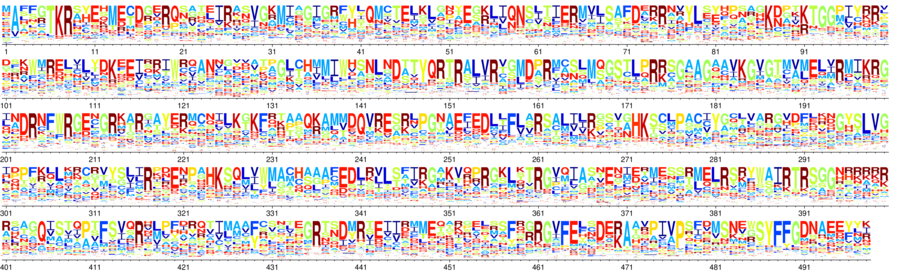

In [2]:
from IPython.display import display
from wand.image import Image as WImage

preferences_pdf_file = preferences_file + ".pdf"

nperline = 100
log = !dms_logoplot {preferences_file} {preferences_pdf_file} --nperline {nperline}

def plot(plot_name, size='900x'):
    print("Here is the selection plot {0}".format(plot_name))
    img = WImage(filename=plot_name, resolution=480)
    img.transform(resize=size)
    display(img)
    
plot(preferences_pdf_file)

## Build SimuEvol

In [3]:
%cd {simuevol_dir}
!make
%cd {experiment_dir}

/home/thibault/SimuEvol
[ 33%] Built target SimuRelax
[ 66%] Built target SimuEvol
[100%] Built target SimuPoly
/home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff


## Forward simulation with SimuPoly

Producing an alignment in .ali and .fasta format (and the .vcf files) from a preferences file and a newick tree.

In [4]:
import subprocess

cmd = exec_simupoly_file
cmd += " --preferences " + preferences_file
cmd += " --newick " + tree_file
cmd += " --nuc_matrix " + nuc_matrix_file
cmd += " --correlation_matrix " + cor_matrix_file
cmd += " --output " + simulation_root

process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, bufsize=1)
print(cmd)

for line in process.stdout:
    print(line.decode().strip(), flush=True)

/home/thibault/SimuEvol/build/SimuPoly --preferences /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/np.txt --newick /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/mammal_subtree.tre --nuc_matrix /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/nucleotide_GTR.tsv --correlation_matrix /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/correlation3x3_zero.tsv --output /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/simulation
The tree is ultrametric.
The equilibrium nucleotides frequencies (ACGT) are:
0.25 0.25 0.25 0.25
The nucleotide rate matrix (ACGT) is:
-1e-08 3.33333e-09 3.33333e-09 3.33333e-09
3.33333e-09      -1e-08 3.33333e-09 3.33333e-09
3.33333e-09 3.33333e-09      -1e-08 3.33333e-09
3.33333e-09 3.33333e-09 3.33333e-09      -1e-08
The correlation matrix is:
0 0 0
0 0 0
0 0 0
The nucleotide rate matrix is time-reversible.
1 blocks created
Burn-in for 50000 generations

## Build BayesCode

In [5]:
%cd {bayescode_dir}
!make
%cd {experiment_dir}

/home/thibault/bayescode
[  3%] Built target mpicomponent_lib
[  6%] Built target tree_lib
[ 10%] Built target tree_test
[ 13%] Built target mpi_par_test
[ 16%] Built target all_tests
[ 50%] Built target bayescode_lib
[ 54%] Built target readmutselomega
[ 57%] Built target datedmutsel
[ 61%] Built target readglobom
[ 64%] Built target globom
[ 67%] Built target aamutsel
[ 71%] Built target dated
[ 76%] Built target multigenecodonm2a
[ 81%] Built target codonm2a
[ 84%] Built target mutselomega
[ 88%] Built target diffseldsparse
[ 91%] Built target readaamutsel
[ 96%] Built target readcodonm2a
[100%] Built target multigeneglobom
/home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff


## Inference with BayesCode

In [6]:
import subprocess

points = 50
nbr_chains = 2
chains = list(range(nbr_chains))

cmd_root = exec_bayescode_file
cmd_root += " -a " + simulation_root + ".ali"
cmd_root += " -t " + tree_file
cmd_root += " -u " + str(points)
cmd_root += " --ncat 10 "

cmds = []
for chain in chains:
    cmds.append(cmd_root + inference_root + "_" + str(chain))
    cmds.append(cmd_root + "-p " + inference_root + "_polymorphism_" + str(chain))

processes = []
for cmd in cmds:
    processes.append(subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, bufsize=1))
    print(cmd)

for process in processes:
    for line in process.stdout:
        print(line.decode().strip(), flush=True)


/home/thibault/bayescode/_build/datedmutsel -a /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/simulation.ali -t /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/mammal_subtree.tre -u 50 --ncat 10 /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/inference_0
/home/thibault/bayescode/_build/datedmutsel -a /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/simulation.ali -t /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/mammal_subtree.tre -u 50 --ncat 10 -p /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/inference_polymorphism_0
/home/thibault/bayescode/_build/datedmutsel -a /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/simulation.ali -t /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/mammal_subtree.tre -u 50 --ncat 10 /home/thibault/SimuEvol/simulated/5b987fd2-9bae-476a-9661-7eb11d5521ff/inference_1
/home/thi

## Plot inference traces

In [7]:
from IPython.display import display
from glob import glob
import matplotlib.pyplot as plt
from csv import reader

header_to_traces = dict()
for trace_file in sorted(glob("{0}/*.trace".format(experiment_dir))):
    name = trace_file.split("/")[-1]
    with open(trace_file, 'r') as trace_open:
        trace = list(reader(trace_open, delimiter='\t'))
        header = "\t".join(trace[0])
        if header not in header_to_traces:
            header_to_traces[header] = dict()
        header_to_traces[header][name] = trace
        
for head, traces in header_to_traces.items():
    for i, param in enumerate(head.split("\t")):
        my_dpi = 128
        fig = plt.figure(figsize=(850 / my_dpi, 320 / my_dpi), dpi=my_dpi)
        for chain, trace in traces.items():
            values = [float(line[i]) for line in trace[1:]]
            plt.plot(range(len(values)), values, alpha=0.5, linewidth=1, label='chain {0}'.format(chain))
        plt.xlabel('Point')
        plt.ylabel(param)
        plt.legend()
        plt.tight_layout()
        plt.show()

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>

<Figure size 850x320 with 1 Axes>